In [1]:
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib_venn import venn2
from amb import *
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from ALLCools.plot import *
age_palette = get_age_palette()
import glob
import pathlib

In [10]:
_dir = 'ABC.By.ATAC.RPM'
ct = 'CA1-ProS_Glut'
_scale = 1000000

In [11]:
gene_meta = pd.read_csv('/home/qzeng_salk_edu/project/240321_abc_score/use.mouse_genes.csv', index_col = 0)
gene_name_to_id= {v:k for k,v in gene_meta['gene_name'].to_dict().items()}

In [12]:
def get_use_df(ct, age):
    df = pd.read_csv(f'{_dir}/{ct}/{ct}.{age}.abc_score.csv', index_col = 0)
    df['norm_contact'] = df['contact'].div(df['contact'].sum()) * _scale
    cutoff = np.percentile(df['contact'], 90)
    df = df[df['contact'] >= cutoff]
    df['gene_id'] = df.index.map(lambda x: x.split('-')[-1])
    df['enhancer_start'] = df.index.map(lambda x: int(x.split(':')[-1].split('-')[0]))
    df['gene_start'] = df['gene_id'].map(gene_meta['start'].to_dict())
    df['gene_end'] = df['gene_id'].map(gene_meta['end'].to_dict())
    
    df['eg_dist'] = np.minimum((df['gene_id'].map(gene_meta['start']) - df['enhancer_start']).abs(),
                                     (df['gene_id'].map(gene_meta['end']) - df['enhancer_start']).abs())
    print(cutoff)
    return df

In [13]:
domain_gene_dir = '/home/qzeng_salk_edu/project/240424_domain_gene/Domain.Genes.Expression'
use_genes = pd.read_csv(f'{domain_gene_dir}/{ct}/DiffExpress.DomainGene.csv', index_col = 0)
use_genes_ids = [gene_name_to_id[gene_name] for gene_name in use_genes.index]
len(use_genes_ids)

81

## plot one gene example

In [ ]:
young_df = get_use_df(ct, '8wk')
old = get_use_df(ct, '18mo')

In [ ]:
use_young_df = young_df[young_df['gene_id'] == gene_name_to_id['Il33']] # Pigk

In [ ]:
fig , axes = plt.subplots(figsize = (6,3), ncols = 2 , dpi = 200, constrained_layout = True)
hue_norm = (0,np.percentile(use_young_df['abc_score'], 95))

ax = axes[0]
sns.scatterplot(data = use_young_df,
                hue = 'abc_score',
                palette = 'viridis',
                hue_norm = hue_norm,
                legend = False,
                x = 'contact',
                y = 'activity',
                ax = ax, 
                s = 6,
                linewidth = 0)

ax = axes[1]
sns.scatterplot(data = use_young_df,
                hue = 'abc_score',
                palette = 'viridis',
                hue_norm = hue_norm,
                legend = False,
                x = 'abc_score',
                y = 'eg_dist',
                ax = ax, 
                s = 6,
                linewidth = 0)
plt.suptitle(f"Il33 Putative Enhancer in {ct}")

## check for all_genes

In [14]:
young_df = get_use_df(ct, '8wk')

5.0


In [15]:
old_df = get_use_df(ct, '18mo')

6.0


In [16]:
young_df =young_df[young_df['gene_id'].isin(use_genes_ids)]
old_df =old_df[old_df['gene_id'].isin(use_genes_ids)]

In [17]:
abc_cutoff = 0.05
young_df = young_df[young_df['abc_score'] >abc_cutoff]
old_df = old_df[old_df['abc_score'] >abc_cutoff]

In [18]:
shared_e_g_pairs = list(set(young_df.index) & set(old_df.index))
shared_df=pd.concat([young_df.loc[shared_e_g_pairs], old_df.loc[shared_e_g_pairs][['activity','contact','abc_score','norm_contact']]], axis = 1)
shared_df.columns = ['8wk.activity', '8wk.contacts','8wk.abc','8wk.norm_contact',
                     'gene_id','gene_start','e_start','e_end','eg_dist',
                     '18mo.activity', '18mo.contacts','18mo.abc','18mo.norm_contact',]

In [19]:
young_num = young_df.shape[0]
old_num = old_df.shape[0]
shared_e_g_pairs_num = shared_df.shape[0]

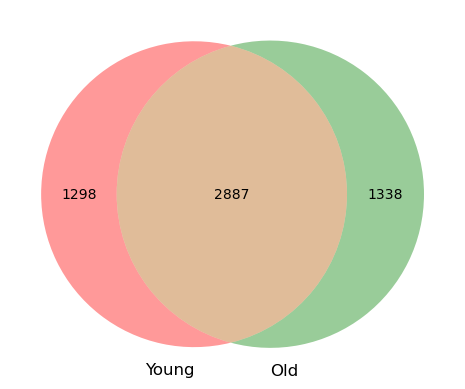

In [20]:
import matplotlib.pyplot as plt
from matplotlib_venn import venn2

venn2(subsets = (young_num-shared_e_g_pairs_num, old_num-shared_e_g_pairs_num, shared_e_g_pairs_num), set_labels = ('Young', 'Old'))
plt.show()

Text(0.5, 1.0, 'Young:0.37Mb Old:0.3Mb')

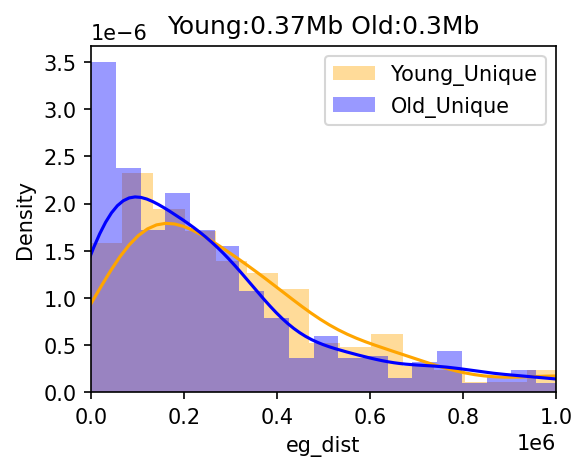

In [23]:
import matplotlib.pyplot as plt
import seaborn as sns

fig, ax = plt.subplots(figsize=(4, 3), dpi=150)

sns.distplot(young_df.loc[~young_df.index.isin(shared_e_g_pairs)]['eg_dist'],
             color='orange', ax=ax, label = 'Young_Unique')
sns.distplot(old_df.loc[~old_df.index.isin(shared_e_g_pairs)]['eg_dist'], 
             color='blue', ax=ax, label = 'Old_Unique')

mean_young = young_df.loc[~young_df.index.isin(shared_e_g_pairs)]['eg_dist'].mean()
mean_old = old_df.loc[~old_df.index.isin(shared_e_g_pairs)]['eg_dist'].mean()
ax.set_xlim(0, 1e6)
ax.legend()
ax.set_title(f"Young:{round(mean_young/1000000,2)}Mb Old:{round(mean_old/1000000,2)}Mb")

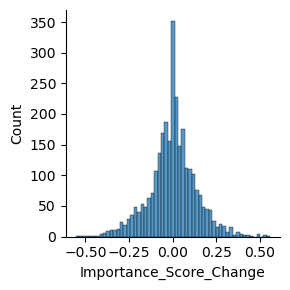

In [24]:
all_to_plot = []
for gene_id , tmpdf in shared_df.groupby('gene_id'):
    tmpdf['Rank_8wk'] = tmpdf['8wk.abc'].rank()
    tmpdf['Rank_18mo'] = tmpdf['18mo.abc'].rank()
    tmpdf['Importance_Score_8wk'] = tmpdf['Rank_8wk']/tmpdf.shape[0]
    tmpdf['Importance_Score_18mo'] = tmpdf['Rank_18mo']/tmpdf.shape[0]
    tmpdf['Importance_Score_Change'] = tmpdf['Importance_Score_18mo'] - tmpdf['Importance_Score_8wk'] 
    all_to_plot.append(tmpdf)
all_to_plot = pd.concat(all_to_plot)
sns.displot(all_to_plot['Importance_Score_Change'], height=3)

In [25]:
def set_cat(x, value):
    if x < -value:
        cat = 'Young Active'
    elif x > value:
        cat = 'Old Active'
    else:
        cat = 'Non Age Dynamic'
    return cat
all_to_plot['Enhancer_Category'] = all_to_plot['Importance_Score_Change'].apply(lambda x: set_cat(x, 0.2))

In [26]:
all_to_plot['contact_change'] = all_to_plot['18mo.norm_contact'] - all_to_plot['8wk.norm_contact']
all_to_plot['activity_change'] = all_to_plot['18mo.activity'] - all_to_plot['8wk.activity']

Text(0.5, 1.0, 'Activity Change (Young-Old)')

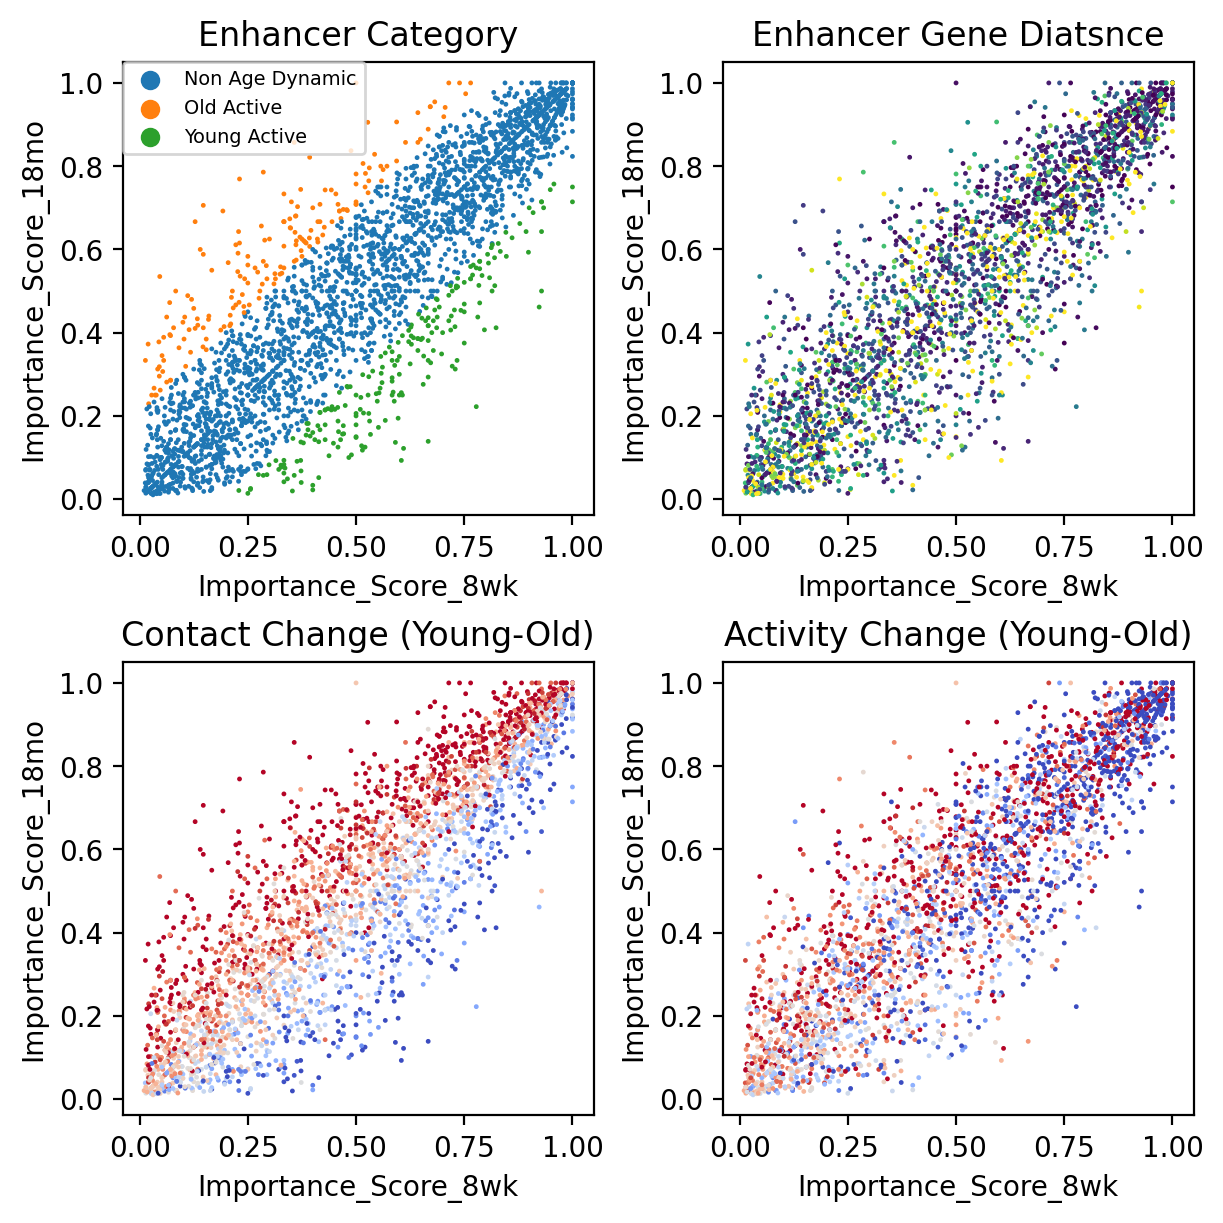

In [27]:
x = 'Importance_Score_8wk'
y = 'Importance_Score_18mo'

fig, axes = plt.subplots(figsize = (6,6), ncols = 2,nrows = 2 ,dpi = 200, constrained_layout = True)

ax= axes[0,0]
sns.scatterplot(data = all_to_plot,
                hue = 'Enhancer_Category',
                linewidth = 0,
                ax = ax,s =3,
                x = x,
                y = y)
ax.legend(loc='upper left', borderaxespad=0,fontsize='x-small') #bbox_to_anchor=(1.05, 1), 
ax.set_title("Enhancer Category")


ax= axes[0,1]
value = np.percentile(all_to_plot['eg_dist'], 90)
sns.scatterplot(data = all_to_plot,
                hue = 'eg_dist',
                palette ='viridis',
                hue_norm = (0,value),
                legend = False,
                linewidth = 0,
                ax = ax,s =3,
                x = x,
                y = y)
ax.set_title("Enhancer Gene Diatsnce")

ax= axes[1,0]
value = np.percentile(all_to_plot['contact_change'], 80)
sns.scatterplot(data = all_to_plot,
                hue = 'contact_change',
                palette ='coolwarm',
                hue_norm = (-value,value),
                legend = False,
                linewidth = 0,
                ax = ax,s =3,
                x = x,
                y = y)
ax.set_title("Contact Change (Young-Old)")

ax= axes[1,1]
value = np.percentile(all_to_plot['activity_change'], 80)
sns.scatterplot(data = all_to_plot,
                hue = 'activity_change',
                palette ='coolwarm',
                hue_norm = (-value,value),
                legend = False,
                linewidth = 0,
                ax = ax,s =3,
                x = x,
                y = y)
ax.set_title("Activity Change (Young-Old)")

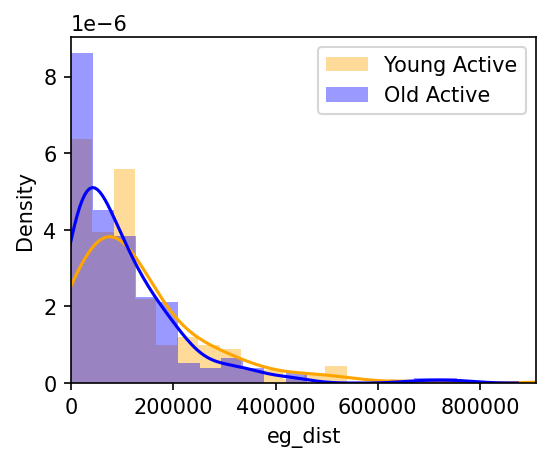

In [29]:
import matplotlib.pyplot as plt
import seaborn as sns
value = np.percentile(all_to_plot['eg_dist'], 99)
fig, ax = plt.subplots(figsize=(4, 3), dpi=150)

sns.distplot(all_to_plot[all_to_plot['Enhancer_Category'] == 'Young Active']['eg_dist'],
             color='orange', ax=ax, label = 'Young Active')
sns.distplot(all_to_plot[all_to_plot['Enhancer_Category'] == 'Old Active']['eg_dist'], 
             color='blue', ax=ax, label = 'Old Active')
ax.set_xlim(0, value)
ax.legend()